From: https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

# Analyzing the frequency components of a signal with a Fast Fourier Transform

In this recipe, we will show how to use a Fast Fourier Transform (FFT) to compute the spectral density of a signal. The spectrum represents the energy associated to frequencies (encoding periodic fluctuations in a signal). It is obtained with a Fourier transform, which is a frequency representation of a time-dependent signal. A signal can be transformed back and forth from one representation to the other with no information loss.

In this recipe, we will illustrate several aspects of the Fourier Transform. We will apply this tool to weather data spanning 20 years in France obtained from the US National Climatic Data Center.

1.  Let's import the packages, including scipy.fftpack, which includes many FFT-related routines:

In [1]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2.  We import the data from the CSV file (it has been obtained at http://www.ncdc.noaa.gov/cdo-web/datasets#GHCND). The number -9999 is used for N/A values. pandas can easily handle this. In addition, we tell pandas to parse dates contained in the **DATE** column:

In [2]:
df0 = pd.read_csv('https://github.com/ipython-books/'
                  'cookbook-2nd-data/blob/master/'
                  'weather.csv?raw=true',
                  na_values=(-9999),
                  parse_dates=['DATE'])
df = df0[df0['DATE'] >= '19940101']
df.head()


,STATION,DATE,PRCP,TMAX,TMIN
365,GHCND:FR013055001,1994-01-01,0.0,104.0,72.0
366,GHCND:FR013055001,1994-01-02,4.0,128.0,49.0
367,GHCND:FR013055001,1994-01-03,0.0,160.0,87.0
368,GHCND:FR013055001,1994-01-04,0.0,118.0,83.0
369,GHCND:FR013055001,1994-01-05,34.0,133.0,55.0


3. Each row contains the precipitation and extreme temperatures recorded each day by one weather station in France. For every date in the calendar, we want to get a single average temperature for the whole country. The **groupby()** method provided by pandas lets us do this easily. We also remove any N/A value with **dropna()**:



In [3]:
df_avg = df.dropna().groupby('DATE').mean(numeric_only=True)
df_avg.head()


,PRCP,TMAX,TMIN
DATE,,,
1994-01-01,178.666667,127.388889,70.333333
1994-01-02,122.000000,152.421053,81.736842
1994-01-03,277.333333,157.666667,95.555556
1994-01-04,177.105263,142.210526,95.684211
1994-01-05,117.944444,130.222222,75.444444


4.  Now, we get the list of dates and the list of corresponding temperatures. The unit is in tenths of a degree, and we get the average value between the minimal and maximal temperature, which explains why we divide by 20.

In [4]:
#date = df_avg.index.to_datetime()
temp = (df_avg['TMAX'] + df_avg['TMIN']) / 20.
N = len(temp)

5.  Let's take a look at the evolution of the temperature:

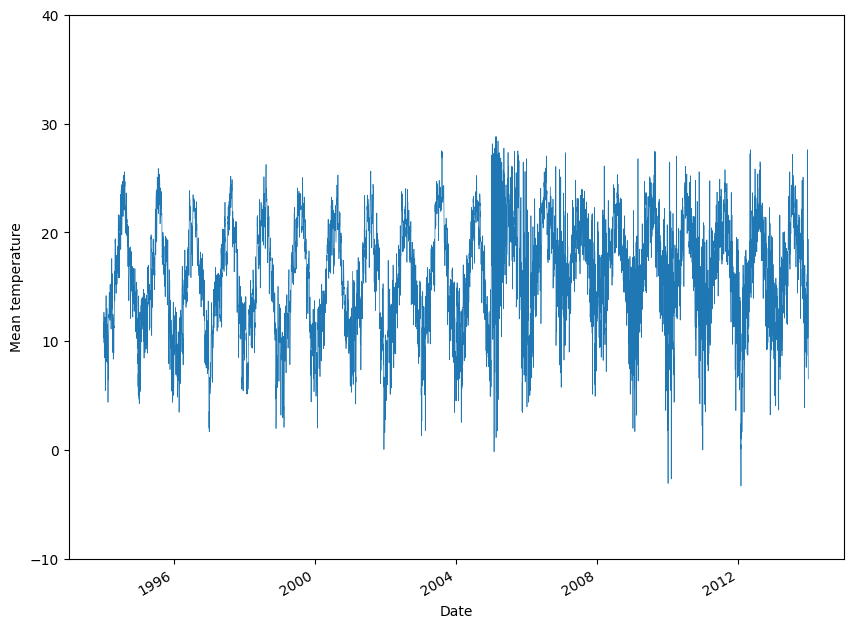

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
temp.plot(ax=ax, lw=.5)
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature');


6.  We now compute the Fourier transform and the spectral density of the signal. The first step is to compute the FFT of the signal using the **fft()** function:


In [6]:
temp_fft = sp.fftpack.fft(temp.to_numpy())

7.  Once the FFT has been obtained, we need to take the square of its absolute value in order to get the **power spectral density (PSD)**:

In [7]:
temp_psd = np.abs(temp_fft) ** 2

8.  The next step is to get the frequencies corresponding to the values of the PSD. The **fftfreq()** utility function does just that. It takes the length of the PSD vector as input as well as the frequency unit. Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365 days). We provide **1/365** because the original unit is in days:

In [8]:
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 365)

9.  The **fftfreq()** function returns positive and negative frequencies. We are only interested in positive frequencies here, as we have a real signal:

In [9]:
i = fftfreq > 0

10. Now let's see which is the maximum frequency for our dataset. Not by chance corrspond to a period of 2 days. Given the 1 day sampling, the Nyquist frequency turns out to be exactly 0.5 day$^{-1}$.

In [10]:
(1./fftfreq.max())*365

2.0005494505494505

11.  We now plot the power spectral density of our signal, as a function of the frequency (in unit of **1/year**). We choose a logarithmic scale for the y axis (decibels):

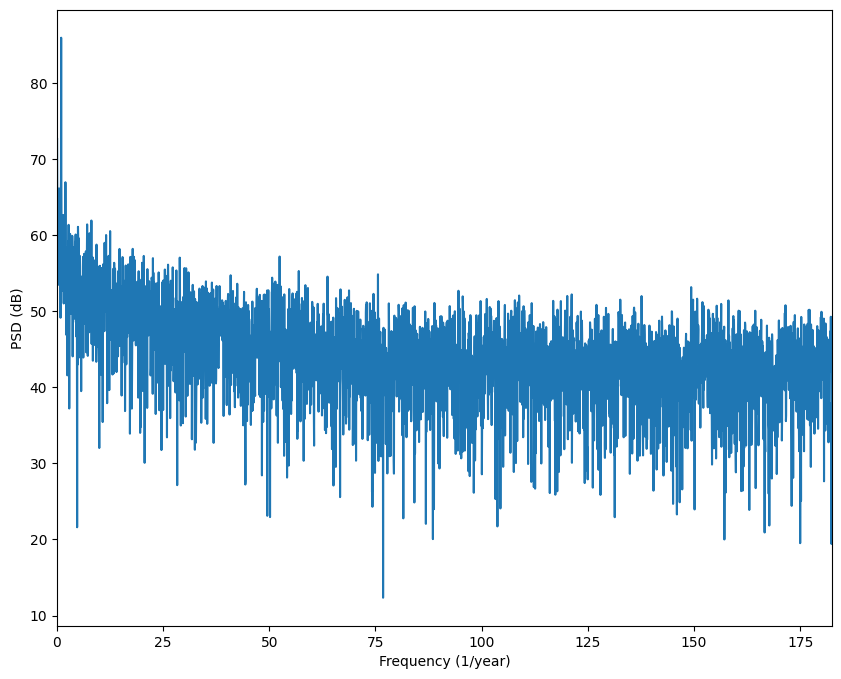

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))

ax.set_xlim(0, fftfreq[i].max())
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)');

12. Or with a better zoom in a region of our interest.

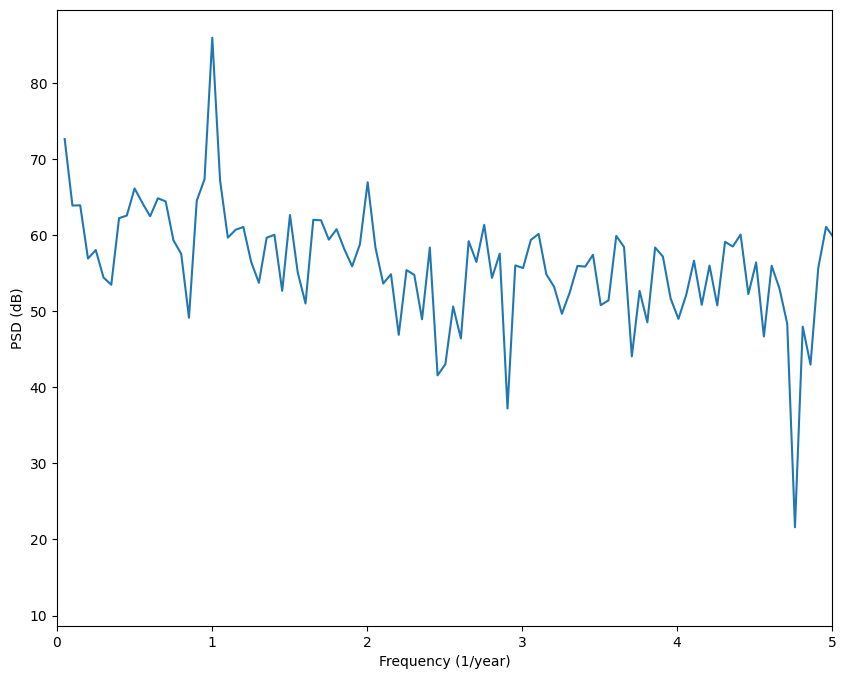

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)');

Because the fundamental frequency of the signal is the yearly variation of the temperature, we observe a peak for **f=1**.

13.  Now, we cut out frequencies higher than the fundamental frequency:

In [13]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0


14.  Next, we perform an **inverse FFT** to convert the modified Fourier transform back to the temporal domain. This way, we recover a signal that mainly contains the fundamental frequency, as shown in the following figure:

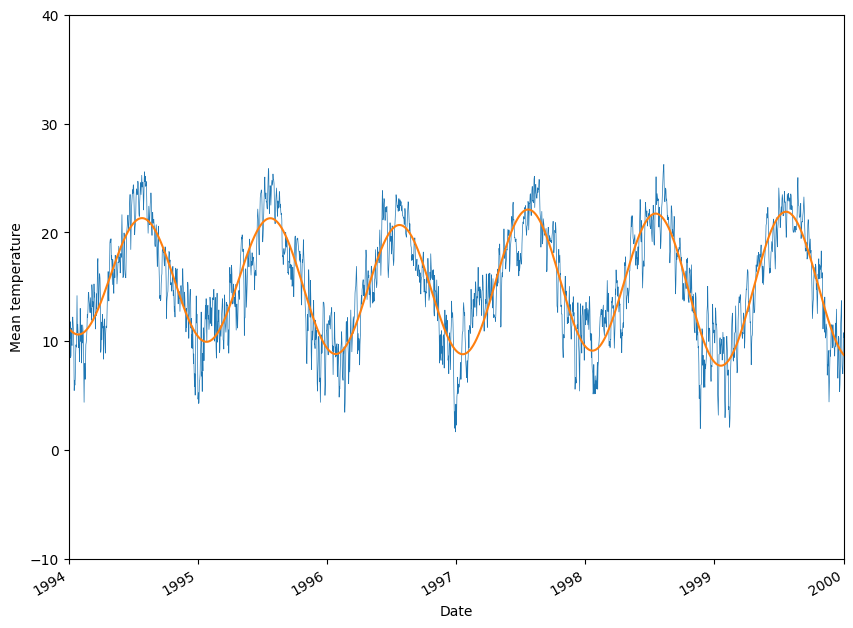

In [14]:
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
temp.plot(ax=ax, lw=.5)
ax.plot_date(df_avg.index, temp_slow, '-')
ax.set_xlim(datetime.date(1994, 1, 1),
            datetime.date(2000, 1, 1))
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature');


We get a smoothed version of the signal, because the fast variations have been lost when we have removed the high frequencies in the Fourier transform.